In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from network_model import *

import sys
#!{sys.executable} -m pip install [arg]
from scipy.stats import gengamma


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
N = 500

In [4]:
g = nx.powerlaw_cluster_graph(n=N, m=2, p=0.5)

In [5]:
W, I, communities, gamma_pos, success, allocations, C = simulation(
    NUM_AGENTS=N,
    STEPS=60,
    PROJECT_COST=0.01,
    graph=g,
    seed=123,
    use_data=False,
    DEFAULT_A=0.5
)

94 communities.
[0.54745263 0.5453357  0.31060423 0.54062644 0.25503807 0.58071004
 0.05015269 0.42477213 0.1202331  0.61707475 0.45363809 0.12956756
 0.46692097 0.23805486 0.56930468 0.5733075  0.77090346 0.5634151
 0.15453682 0.54542164 0.4498735  0.07986672 0.49599333 0.3754455
 0.25629897 0.67410897 0.42303788 0.48565739 0.26395262 0.2799658
 0.84351645 0.24938529 0.39765531 0.68570895 0.27822339 0.80800668
 0.73966043 0.0810717  0.21998196 0.42777324 0.27206472 0.20148361
 0.32057479 0.1831121  0.15537401 0.73122289 0.65695183 0.05294276
 0.30865345 0.64683747 0.5519352  0.33867848 0.10413485 0.37452982
 0.81770315 0.41398628 0.1837136  0.30514614 0.43373769 0.31117037
 0.49657686 0.55773778 0.2212212  0.325194   0.40357155 0.49487603
 0.16665166 0.85189782 0.66134736 0.59988392 0.1991124  0.17382605
 0.34264634 0.12802471 1.02385459 0.22740676 0.30278799 0.32439726
 0.24326368 0.20771763 0.34602719 0.39495391 0.25538412 0.35973358
 0.03766633 0.22456261 0.49311508 0.30792574 0.57

  0%|          | 0/500 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 500/500 [02:29<00:00,  3.35it/s]


Performing time stepping...


100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


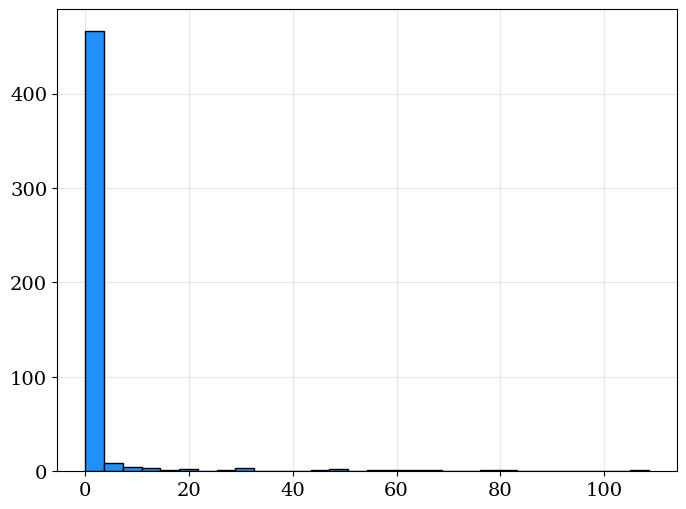

In [9]:
plt.hist(W[-1], bins=30, color="dodgerblue", edgecolor="k")
plt.show()

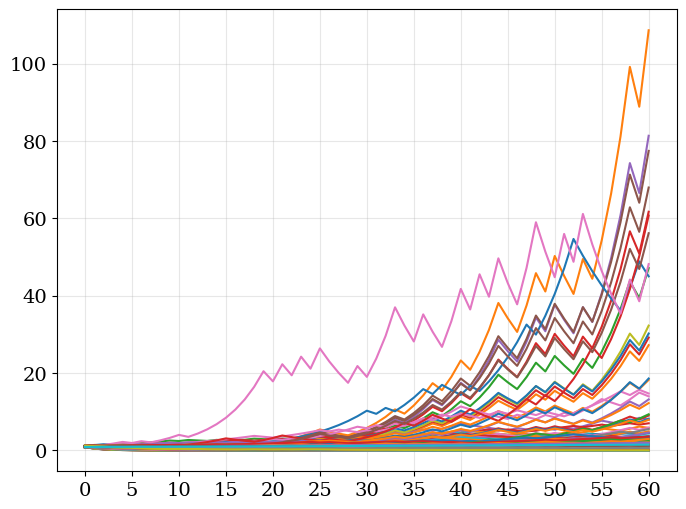

In [10]:
for i in range(W.shape[1]):
    plt.plot(W[:,i])

plt.xticks(np.arange(0, len(W), 5))
plt.show()

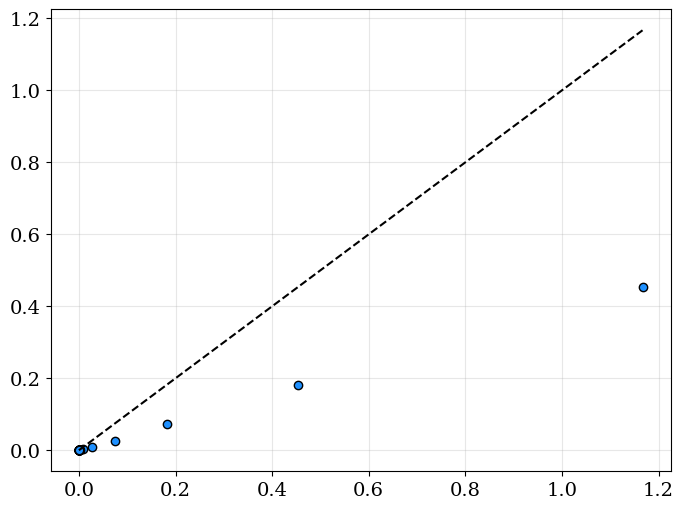

In [13]:
i = 10

x=[]
y=[]
for k in range(len(W)-1):
    x.append(W[k][i])
    y.append(W[k+1][i])

plt.scatter(x,y, color="dodgerblue", edgecolor="k")
plt.plot(np.linspace(min(x), max(x), 100), np.linspace(min(x), max(x), 100), color="k", linestyle="dashed")
plt.show()